In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))



from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

In [2]:
casestore = {}

In [16]:

db = CaseDB(
    # case_dir = r"/ssd_scratch/hcases",
    # grid_dir = r"/ssd_scratch/hcases"
    )

toload = [

    # dict(name="base", id="x4a1-base_mc", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="new-defaults", id="x4a2-new_default_bcs", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="tn_30eV", id="x4a3-tn_30ev", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="fastbase", id="x5a1-quicker_base", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="base", id="x5a1b-fluxes_branch", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="base", id="c7a-c4e_aa_fix", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = False),
    # dict(name="base", id="x5a2-better_base", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="base", id="x5a2h-better_base_oldmaster", grid="g3b1-lores_newhypno.nc", unnormalise_geom = False),
    # dict(name="base", id="d14b-edgerec_no_Tnfix", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    
    # dict(name="base", id="x5a2b-better_base_edge_recycling", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="base", id="x5a2c-free_edge", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="base", id="x5a2d-decaylength", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="base", id="x5a2br-better_base_edge_recycling_rerun", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),

]


for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                            unnormalise_geom = case["unnormalise_geom"])


CHECK: Total domain volume is 1.607E+00 [m3]


In [126]:
6*np.sqrt(2)

8.485281374238571

# New particle balance

In [ ]:

ds = casestore["base"].ds

ds = calculate_target_fluxes(ds)
ds = calculate_radial_fluxes(ds, force_neumann = True)
ds = calculate_particle_balance(ds)
show_particle_balance_table(ds)

## Old particle balance

In [17]:
ds = casestore["base"].ds

ds = calculate_target_fluxes(ds)
ds = calculate_radial_fluxes(ds, force_neumann = False)
# ds = calculate_particle_balance(ds)
# show_particle_balance_table(ds)

Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper


In [95]:
show_particle_balance_table(ds)

---------------------------------------
PARTICLE BALANCE
---------------------------------------
Domain volume: 8.613e-08 [m3]
Particle imbalance: 1.460e+18 [s-1]
Particle imbalance as frac of core + source: 98.62%
---------------------------------------
Total fluxes in [s-1]:


,d+,d,total
source,0.00e+00,5.32e+13,5.32e+13
core,1.48e+18,0.00e+00,1.48e+18
sol,0.00e+00,0.00e+00,0.00e+00
pfr,0.00e+00,0.00e+00,0.00e+00
targets,-4.08e+17,3.88e+17,-2.04e+16
iz,1.43e+15,-1.43e+15,0.00e+00
rec,-7.47e+10,7.47e+10,0.00e+00


# New format balance execution

In [18]:
ds = casestore["base"].ds
ds = make_balance(ds)
net = sum_balances(ds)

Sd_sol_recycle not found
Sd_pfr_recycle not found
pf_int_recycle_sol_d not found
pf_int_recycle_pfr_d not found


In [13]:
net.keys()

dict_keys(['src', 'core', 'sol', 'pfr', 'recycle_sol', 'recycle_pfr', 'inner_lower_target', 'outer_lower_target', 'inner_upper_target', 'outer_upper_target', 'recycle_inner_lower_target', 'recycle_outer_lower_target', 'recycle_inner_upper_target', 'recycle_outer_upper_target', 'targets', 'recycle_targets', 'targets_net'])

In [19]:
df = pd.DataFrame()
# df.index = ["src", "core", "sol", "sol recycle", "pfr", "pfr recycle", "net_targets"]
m = ds.metadata
balance = 0

for place in ["src", "core", "sol", "recycle_sol", "pfr", "recycle_pfr", "targets_net"]:
    if not isinstance(net[place], int):
        df.loc[place, "Value"] = net[place].isel(t=-1)
        balance += net[place]
    
df

,Value
src,0.000000e+00
core,3.077499e+20
sol,0.000000e+00
pfr,0.000000e+00
targets_net,-3.533835e+20


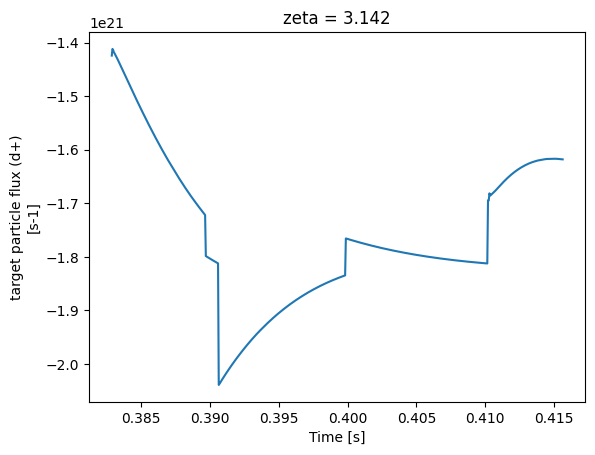

In [15]:
net["targets_net"].plot()


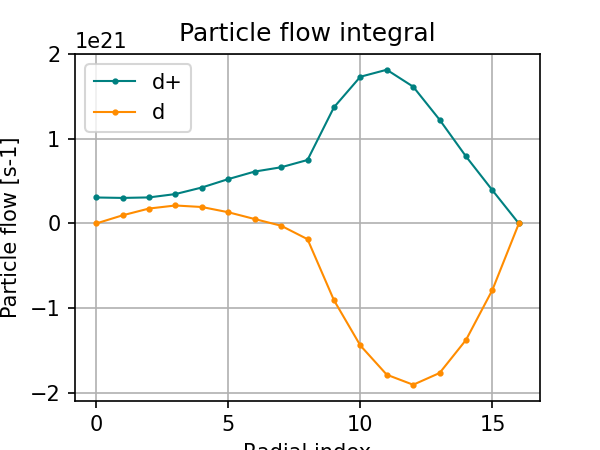

In [103]:
plot_perp_particle_fluxes(ds.isel(t=-1))

# NEW FORMAT

In [9]:
def make_balance(ds):
    m = ds.metadata
        
    core = ds.hermesm.select_region("core_edge")
    sol = ds.hermesm.select_region("sol_edge")
    pfr = ds.hermesm.select_region("pfr_edge")
    domain = ds.hermesm.select_region("all_noguards").squeeze()
    domain_volume = domain["dv"].values.sum()
    variables = ds.data_vars

    ### Calculate all integrals of edge flows and sources
    for species in m["ion_species"] + m["neutral_species"]:
        ds[f"pf_int_src_{species}"] = (domain[f"S{species}_src"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_core_{species}"] = core[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()
        ds[f"pf_int_sol_{species}"] = sol[f"pf_perp_diff_R_{species}"].sum("theta").squeeze() * -1 # Positive is going right, which is flowing OUT
        ds[f"pf_int_pfr_{species}"] = pfr[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()
        
    ### Calculate integrals of recycling at edges
    for species in m["recycle_pair"].values():
        
        ## SOL
        name = f"S{species}_sol_recycle"
        if name in variables:
            ds[f"pf_int_recycle_sol_{species}"] = (domain[f"S{species}_sol_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
        else:
            print(f"{name} not found")
            
        ## PFR
        name = f"S{species}_pfr_recycle"
        if name in variables:
            ds[f"pf_int_recycle_pfr_{species}"] = (domain[f"S{species}_pfr_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
        else:
            print(f"{name} not found")
            
    
    ### Calculate integrals of target flows       
    ## Capture ion species (flows leaving model)
    for species in m["ion_species"]:
        for target_name in m["targets"]:
            ds[f"pf_int_{target_name}_target_{species}"] = ds[f"pf_{target_name}_target_{species}"].sum("x").squeeze()
            
    ## Capture recycled species (sources entering model)
    for species in m["recycle_pair"].values():
        for target_name in m["targets"]:
            ds[f"pf_int_recycle_{target_name}_target_{species}"] = ds[f"pf_recycle_{target_name}_target_{species}"].sum("x").squeeze()

    ### Atomic reaction flows
    for ion in m["ion_species"]:
        
        name = f"S{ion}_iz"
        if name in variables:
            neutral = ion.split("+")[0]
            ds[f"pf_int_iz_{ion}"] = (domain[f"S{ion}_iz"] * domain["dv"]).sum(["x", "theta"]).squeeze()
            ds[f"pf_int_iz_{neutral}"] = ds[f"pf_int_iz_{ion}"] * -1
        else:
            print(f"{name} not found")
        
        name = f"S{ion}_rec"
        if name in variables:
            ds[f"pf_int_rec_{ion}"] = (domain[f"S{ion}_rec"] * domain["dv"]).sum(["x", "theta"]).squeeze()
            ds[f"pf_int_rec_{neutral}"] = ds[f"pf_int_rec_{ion}"] * -1
        else:
            print(f"{name} not found")
            
    return ds

    
# Recycling from targets
# for species in m["recycle_pair"].values():
#     for target_name in m["targets"]:
#         kind = target_name + "_target"
#         name = f"pf_int_recycle_{target_name}_target_{species}"
#         if name in variables:
#             net[f"{kind}"] += ds[name]

In [10]:
def sum_balances(ds):
    """
    Sums flows for all species
    """
    variables = ds.data_vars
    m = ds.metadata
    
    ### Calculate totals per location/source, no matter what the species
    net = dict()
    ## Regular sources and edges
    for kind in ["src", "core", "sol", "pfr"]:
        net[kind] = 0
        for species in m["ion_species"] + m["neutral_species"]:
            net[kind] += ds[f"pf_int_{kind}_{species}"]

    ## Recycling from edges
    for kind in ["recycle_sol", "recycle_pfr"]:
        net[kind] = 0
        for species in m["recycle_pair"].values():
            name = f"pf_int_{kind}_{species}"
            if name in variables:
                net[kind] += ds[name]
            else:
                print(f"{name} not found")
                
    ## Reactions are not a net particle sink or source so are not included
            
    ## Targets
    # Flows in or out of targets
    for target_name in m["targets"]:
        kind = f"{target_name}_target"
        net[f"{kind}"] = 0
        
        for species in m["ion_species"]:
            name = f"pf_int_{kind}_{species}"
            
            if name in variables:
                net[f"{kind}"] += ds[name]
            else:
                print(f"{name} not found")
                
    # Recycling from targets         
    for target_name in m["targets"]:
        kind = f"recycle_{target_name}_target"
        net[f"{kind}"] = 0
        
        for species in m["recycle_pair"].values():
            name = f"pf_int_{kind}_{species}"
            
            if name in variables:
                net[f"{kind}"] += ds[name]
            else:
                print(f"{name} not found")
                
    ## Sum targets
    net["targets"] = 0
    net["recycle_targets"] = 0

    for target_name in m["targets"]:
        net["targets"] += net[f"{target_name}_target"]
        net["recycle_targets"] += net[f"recycle_{target_name}_target"]

    net["targets_net"] = net["targets"] + net["recycle_targets"]
    
    return net

In [5]:
casestore["base"].ds.data_vars

Data variables:
    Bxy                   (x, theta) float64 dask.array<chunksize=(8, 7), meta=np.ndarray>
    Dnnd                  (t, x, theta) float64 dask.array<chunksize=(629, 8, 7), meta=np.ndarray>
    Ed+_iz                (t, x, theta) float64 dask.array<chunksize=(629, 8, 7), meta=np.ndarray>
    Ed+_rec               (t, x, theta) float64 dask.array<chunksize=(629, 8, 7), meta=np.ndarray>
    Ed_pfr_recycle        (t, x, theta) float64 dask.array<chunksize=(629, 8, 7), meta=np.ndarray>
    Ed_sol_recycle        (t, x, theta) float64 dask.array<chunksize=(629, 8, 7), meta=np.ndarray>
    Ed_target_recycle     (t, x, theta) float64 dask.array<chunksize=(629, 8, 7), meta=np.ndarray>
    Edd+_cx               (t, x, theta) float64 dask.array<chunksize=(629, 8, 7), meta=np.ndarray>
    EnergyFlow_d+_xlow    (t, x, theta) float64 dask.array<chunksize=(629, 8, 7), meta=np.ndarray>
    EnergyFlow_d+_ylow    (t, x, theta) float64 dask.array<chunksize=(629, 8, 7), meta=np.ndarray>
  

In [ ]:
def sum_detailed_balances(ds):
    """
    Sums flows for all species
    """
    variables = ds.data_vars
    m = ds.metadata
    
    ### Calculate totals per location/source, no matter what the species
    net = dict()
    ## Regular sources and edges
    for kind in ["src", "core", "sol", "pfr"]:
        for species in m["ion_species"] + m["neutral_species"]:
            net[f"{kind}_{species}"] = ds[f"pf_int_{kind}_{species}"]

    ## Recycling from edges
    for kind in ["recycle_sol", "recycle_pfr"]:
        net[kind] = 0
        for species in m["recycle_pair"].values():
            name = f"pf_int_{kind}_{species}"
            if name in variables:
                net[kind] += ds[name]
            else:
                print(f"{name} not found")
                
    ## Reactions are not a net particle sink or source so are not included
            
    ## Targets
    # Flows in or out of targets
    for target_name in m["targets"]:
        kind = f"{target_name}_target"
        net[f"{kind}"] = 0
        
        for species in m["ion_species"]:
            name = f"pf_int_{kind}_{species}"
            
            if name in variables:
                net[f"{kind}"] += ds[name]
            else:
                print(f"{name} not found")
                
    # Recycling from targets         
    for target_name in m["targets"]:
        kind = f"recycle_{target_name}_target"
        net[f"{kind}"] = 0
        
        for species in m["recycle_pair"].values():
            name = f"pf_int_{kind}_{species}"
            
            if name in variables:
                net[f"{kind}"] += ds[name]
            else:
                print(f"{name} not found")
                
    ## Sum targets
    net["targets"] = 0
    net["recycle_targets"] = 0

    for target_name in m["targets"]:
        net["targets"] += net[f"{target_name}_target"]
        net["recycle_targets"] += net[f"recycle_{target_name}_target"]

    net["targets_net"] = net["targets"] + net["recycle_targets"]
    
    return net

In [156]:
df = pd.DataFrame()
df.index = ["source", "core", "sol", "sol recycle", "pfr", "pfr recycle", "targets", "targets recycle", "iz", "rec"]
m = ds.metadata

if f"pf_int_{m['targets'][0]}" in ds.data_vars:
    merge_targets = False
else:
    merge_targets = True

last = ds.isel(t=-1)
for species in m["ion_species"] + m["neutral_species"]:
    df.loc["source", species] = last[f"pf_int_src_{species}"]
    df.loc["core", species] = last[f"pf_int_core_{species}"]
    df.loc["sol", species] = last[f"pf_int_sol_{species}"]
    df.loc["pfr", species] = last[f"pf_int_pfr_{species}"]
    
for species in m["ion_species"]:
    if merge_targets is True:
        df.loc["targets", species] = last[f"pf_int_targets_{species}"]
    else:
        for target in m["targets"]:
            df.loc[target, species] = last[f"pf_int_{target}_{species}"]
    
for species in m["ion_species"] + m["neutral_species"]:
    if f"pf_int_iz_{species}" in last.keys():
        df.loc["iz", species] = last[f"pf_int_iz_{species}"]
    if f"pf_int_rec_{species}" in last.keys():
        df.loc["rec", species] = last[f"pf_int_rec_{species}"]
        
for species in m["recycle_pair"].values():
    if f"pf_int_recycle_sol_{species}" in vars:
        df.loc["sol recycle", species] = last[f"pf_int_recycle_sol_{species}"]
    if f"pf_int_recycle_pfr_{species}" in vars:
        df.loc["pfr recycle", species] = last[f"pf_int_recycle_pfr_{species}"]
    if f"pf_int_recycle_targets_{species}" in vars:
        df.loc["targets recycle", species] = last[f"pf_int_recycle_target_{species}"]
    
df["total"] = df.sum(axis=1)
imbalance = df["total"].sum()
imbalance_frac = imbalance / (df["total"]["source"] + df["total"]["core"])

# print(f"Recycling fraction: {frec:.2%}")
print(f"Domain volume: {ds['dv'].sum():.3e} [m3]")
print(f"Particle imbalance: {imbalance:,.3e} [s-1]")
print(f"Particle imbalance as frac of core + source: {imbalance_frac:.2%}")
print("---------------------------------------")
print(f"Total fluxes in [s-1]:")

def styler(s):
        if abs(s) < 0.01 or pd.isna(s):
            c =  "color: lightgrey"
        else:
            c =  "color: black"

        return c
        
ts = df.copy().style.format("{:.2e}")
ts = ts.applymap(styler)
display(ts)

TypeError: argument of type 'builtin_function_or_method' is not iterable

# OLD FORMAT

In [27]:
ds = casestore["reference"].ds

m = ds.metadata
    
core = ds.hermesm.select_region("core_edge")
sol = ds.hermesm.select_region("sol_edge")
pfr = ds.hermesm.select_region("pfr_edge")
domain = ds.hermesm.select_region("all_noguards").squeeze()
domain_volume = domain["dv"].values.sum()
vars = ds.data_vars

df = pd.DataFrame()
pf = dict()

# Radial and edge fluxes
# The summing is clunky but there's apparently no other way in Xarray!
net = dict()

for place in ["src", "core", "sol", "pfr"]:
    net[f"pf_int_{place}_net"] = 0

### Calculate all integrals of edge fluxes and sources
for species in m["ion_species"] + m["neutral_species"]:
    ds[f"pf_int_src_{species}"] = (domain[f"S{species}_src"] * domain["dv"]).sum(["x", "theta"]).squeeze()
    ds[f"pf_int_core_{species}"] = core[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()
    ds[f"pf_int_sol_{species}"] = sol[f"pf_perp_diff_R_{species}"].sum("theta").squeeze() * -1 # Positive is going right, which is flowing OUT
    ds[f"pf_int_pfr_{species}"] = pfr[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()

    # Add to net counter for each location
    for place in ["src", "core", "sol", "pfr"]:
        net[f"pf_int_{place}_net"] += ds[f"pf_int_{place}_{species}"]
    
### Calculate all integrals of recycling sources
for species in m["recycle_pair"].values():
    if f"S{species}_sol_recycle" in vars:
        ds[f"pf_int_recycle_sol_{species}"] = (domain[f"S{species}_sol_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
    if f"S{species}_pfr_recycle" in vars:
        ds[f"pf_int_recycle_pfr_{species}"] = (domain[f"S{species}_pfr_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
    if f"S{species}_target_recycle" in vars:
        ds[f"pf_int_recycle_target_{species}"] = (domain[f"S{species}_target_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
        
    # Add to net counters for each location apart from sources since there are no user set recycling sources
    # Also add to the targets net counter (recycling sources per target basis not done yet)
    for place in ["sol", "pfr", "targets"]:   # No recycling in core, but yes in targets
        if f"pf_int_recycle_{place}_{species}" in vars:
            net[f"pf_int_{place}_net"] += ds[f"pf_int_recycle_{place}_{species}"]
    
### Calculate integrals of target fluxes
# Initialise per-target net counter
for target_name in m["targets"]:
    net[target_name] = 0
net["targets"] = 0
net["targets_recycle"] = 0


        
## Capture ion species (flux leaving model)
for species in m["ion_species"]:
    net[f"targets_{species}"] = 0 # TODO: Not sure why we need a net per species?
    
    
    for target_name in m["targets"]:
        ds[f"pf_int_{target_name}_target_{species}"] = ds[f"pf_{target_name}_target_{species}"].sum("x").squeeze()
        net[target_name] += ds[f"pf_int_{target_name}_target_{species}"]   # Ion flux
        net[f"targets_{species}"] += ds[f"pf_int_{target_name}_target_{species}"] # TODO: Not sure why we need a net per species?
    
## Capture recycled species (sources entering model)
for species in m["recycle_pair"].values():
    net[f"targets_{species}"] = 0 # TODO: Not sure why we need a net per species?
    net[f"targets_recycle_{species}"] = 0
    
    for target_name in m["targets"]:
        ds[f"pf_int_recycle_{target_name}_target_{species}"] = ds[f"pf_recycle_{target_name}_target_{species}"].sum("x").squeeze()
        net[target_name] += ds[f"pf_int_recycle_{target_name}_target_{species}"]   # Recycling flux
        net[f"targets_recycle_{species}"] += ds[f"pf_int_recycle_{target_name}_target_{species}"] # TODO: Not sure why we need a net per species?
        net[f"targets_recycle"] += ds[f"pf_int_recycle_{target_name}_target_{species}"] # TODO: Not sure why we need a net per species?
        
for species in m["ion_species"] + list(m["recycle_pair"].values()):
    ds[f"pf_int_targets_{species}"] = net[f"targets_{species}"] # TODO: Not sure why we need a net per species?
        
# Get the all target net counter
# Put the net counters into the dataset
for target_name in m["targets"]:
    ds[f"pf_int_{target_name}_target_net"] = net[target_name]
    net["targets"] += net[target_name]
    
ds[f"pf_int_targets_net"] = net["targets"]


### Atomic reaction fluxes
for ion in m["ion_species"]:
    
    if f"S{ion}_iz" in domain.data_vars:
        neutral = ion.split("+")[0]
        ds[f"pf_int_iz_{ion}"] = (domain[f"S{ion}_iz"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_iz_{neutral}"] = ds[f"pf_int_iz_{ion}"] * -1
    
    if f"S{ion}_rec" in domain.data_vars:
        ds[f"pf_int_rec_{ion}"] = (domain[f"S{ion}_rec"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_rec_{neutral}"] = ds[f"pf_int_rec_{ion}"] * -1

# Note: no "net" ionisation or recombination since they net out to zero.

### Put the net sums in each location into the dataset
for place in ["src", "core", "sol", "pfr"]:
    ds[f"pf_int_{place}_net"] = net[f"pf_int_{place}_net"]
    
for target_name in m["targets"]:
    ds[f"pf_int_{target_name}_target_net"] = net[target_name]
    net["targets"] += net[target_name]
    
ds[f"pf_int_targets_net"] = net["targets"]
ds[f"pf_int_recycle_targets_net"] = net["targets_recycle"]

### Calculate the total net balance
ds[f"pf_int_total_net"] = \
    ds["pf_int_src_net"] + ds["pf_int_core_net"] + ds["pf_int_sol_net"] + ds["pf_int_pfr_net"] \
        + ds["pf_int_targets_net"]

In [29]:
ds["pf_int_recycle_targets_net"].values

array([2.78864676e+22, 2.68721439e+22, 2.58833856e+22, 2.49635448e+22,
       2.41294553e+22, 2.33913051e+22, 2.27485175e+22, 2.22070606e+22,
       2.17598977e+22, 2.14014011e+22, 2.11244743e+22, 2.09211052e+22,
       2.07811119e+22, 2.06960878e+22, 2.06577572e+22, 2.06587022e+22,
       2.06922162e+22, 2.07522269e+22, 2.08333432e+22, 2.07622636e+22,
       2.07011508e+22, 2.06592682e+22, 2.06355862e+22, 2.06276473e+22,
       2.06352585e+22, 2.06560735e+22, 2.06878974e+22, 2.07287462e+22,
       2.07767921e+22, 2.08303496e+22, 2.08879269e+22, 2.09481890e+22,
       2.10099376e+22, 2.10721732e+22, 2.11340313e+22, 2.11947855e+22,
       2.12541004e+22, 2.13107516e+22, 2.13651178e+22, 2.14164515e+22,
       2.11174799e+22, 2.08228397e+22, 2.05555706e+22, 2.03200828e+22,
       2.01185496e+22, 1.99503536e+22, 1.98133278e+22, 1.97047878e+22,
       1.96218618e+22, 1.95617558e+22, 1.95214537e+22, 1.94980928e+22,
       1.94890270e+22, 1.94918284e+22, 1.95043736e+22, 1.95247300e+22,
      

In [28]:
df = pd.DataFrame()
df.index = ["source", "core", "sol", "sol recycle", "pfr", "pfr recycle", "targets", "targets recycle", "iz", "rec"]
m = ds.metadata

if f"pf_int_{m['targets'][0]}" in ds.data_vars:
    merge_targets = False
else:
    merge_targets = True

last = ds.isel(t=-1)
for species in m["ion_species"] + m["neutral_species"]:
    df.loc["source", species] = last[f"pf_int_src_{species}"]
    df.loc["core", species] = last[f"pf_int_core_{species}"]
    df.loc["sol", species] = last[f"pf_int_sol_{species}"]
    df.loc["pfr", species] = last[f"pf_int_pfr_{species}"]
    
for species in m["ion_species"]:
    if merge_targets is True:
        df.loc["targets", species] = last[f"pf_int_targets_{species}"]
    else:
        for target in m["targets"]:
            df.loc[target, species] = last[f"pf_int_{target}_{species}"]
    
for species in m["ion_species"] + m["neutral_species"]:
    if f"pf_int_iz_{species}" in last.keys():
        df.loc["iz", species] = last[f"pf_int_iz_{species}"]
    if f"pf_int_rec_{species}" in last.keys():
        df.loc["rec", species] = last[f"pf_int_rec_{species}"]
        
for species in m["recycle_pair"].values():
    if f"pf_int_recycle_sol_{species}" in vars:
        df.loc["sol recycle", species] = last[f"pf_int_recycle_sol_{species}"]
    if f"pf_int_recycle_pfr_{species}" in vars:
        df.loc["pfr recycle", species] = last[f"pf_int_recycle_pfr_{species}"]
    if f"pf_int_recycle_targets_{species}" in vars:
        df.loc["targets recycle", species] = last[f"pf_int_recycle_target_{species}"]
    
df["total"] = df.sum(axis=1)
imbalance = df["total"].sum()
imbalance_frac = imbalance / (df["total"]["source"] + df["total"]["core"])

# print(f"Recycling fraction: {frec:.2%}")
print(f"Domain volume: {ds['dv'].sum():.3e} [m3]")
print(f"Particle imbalance: {imbalance:,.3e} [s-1]")
print(f"Particle imbalance as frac of core + source: {imbalance_frac:.2%}")
print("---------------------------------------")
print(f"Total fluxes in [s-1]:")

def styler(s):
        if abs(s) < 0.01 or pd.isna(s):
            c =  "color: lightgrey"
        else:
            c =  "color: black"

        return c
        
ts = df.copy().style.format("{:.2e}")
ts = ts.applymap(styler)
display(ts)

Domain volume: 1.942e+00 [m3]
Particle imbalance: -2.005e+22 [s-1]
Particle imbalance as frac of core + source: -1336.88%
---------------------------------------
Total fluxes in [s-1]:


,d+,d,total
source,3.00e+20,1.20e+21,1.50e+21
core,0.00e+00,0.00e+00,0.00e+00
sol,-0.00e+00,-0.00e+00,0.00e+00
sol recycle,nan,nan,0.00e+00
pfr,0.00e+00,0.00e+00,0.00e+00
pfr recycle,nan,nan,0.00e+00
targets,-2.16e+22,nan,-2.16e+22
targets recycle,nan,nan,0.00e+00
iz,2.13e+22,-2.13e+22,0.00e+00
rec,-7.29e+18,7.29e+18,0.00e+00


In [20]:
"pf_int_recycle_targets_d" in vars

False

# Target check

In [ ]:
flow = net["targets"].isel(t=-1).values
rec = net["recycle_targets"].isel(t=-1).values
print(rec)
print(flow)

6.644867001366177e+21
-6.994596843543343e+21


In [ ]:
(abs(rec) - abs(flow))/abs(flow)

-0.04999999999999991

In [ ]:
a = ds["pf_int_outer_lower_target_d+"].isel(t=-1).values

In [ ]:
_, _, pf = sheath_boundary_simple(ds, "d+", "outer_lower" ,sheath_ion_polytropic=1.0, include_convective=True)

pf = pf.isel(t=-1)
pf.values.sum()

-2.590532407545682e+21

In [ ]:
total = 0
m = ds.metadata
for name in m["targets"]:
    target = ds.hermesm.select_region(f"{name}_target").isel(t=-1)#.mean("x")
    guards = ds.hermesm.select_region(f"{name}_target_inner_guards").isel(t=-1)#.mean("x")
    # plot_selection(ds, guards)

    def wall(param):
        return ((target[param] + guards[param]) / 2).values

    area = wall("dx") * wall("dz") * wall("J") / np.sqrt(wall("g_22"))
    Ne = wall("Ne")
    flux = abs(wall("Vd+")) * wall("Ne")
    flow = flux * area
    b = flow.sum()
    total += b
    
    a = ds[f"pf_int_{name}_d+"].isel(t=-1).values
    # print(Ne)
    print(f"{name}: This calc: {flow.sum():.3e} || Flux calc: {a:.3e}")
print("Total:",total)
    # target["Ne"].values

inner_lower: This calc: 0.000e+00 || Flux calc: -9.360e+20
outer_lower: This calc: 0.000e+00 || Flux calc: -2.591e+21
inner_upper: This calc: 0.000e+00 || Flux calc: -9.421e+20
outer_upper: This calc: 0.000e+00 || Flux calc: -2.571e+21
Total: 0.0


In [ ]:
name = "outer_lower"
target = ds.hermesm.select_region(f"{name}_target").isel(t=-1)#.mean("x")
guards = ds.hermesm.select_region(f"{name}_target_inner_guards").isel(t=-1)#.mean("x")
# plot_selection(ds, guards)

def wall(param):
    return ((target[param].values + guards[param].values) / 2)

area = wall("dx") * wall("dz") * wall("J") / np.sqrt(wall("g_22"))
Ne = wall("Ne")
Vi = wall("Vd+")
flux = abs(Vi) * Ne
flow = flux * area

a = abs(ds[f"pf_int_{name}_d+"].isel(t=-1).values)   # Flux calc
b = flow.sum()   # This calc
_, _, c = sheath_boundary_simple(ds, "d+", name)
c = abs(c.isel(t=-1).sum())

print(f"THIS CALC: {Vi.mean()}")

print(f"{name}: This calc: {flow.sum():.3e} || Flux calc: {a:.3e} || Flux calc redone: {c:.3e}")

THIS CALC: 18699.429206299737
outer_lower: This calc: 2.547e+21 || Flux calc: 2.569e+21 || Flux calc redone: 2.569e+21


In [ ]:
plt.close("all")
%matplotlib widget

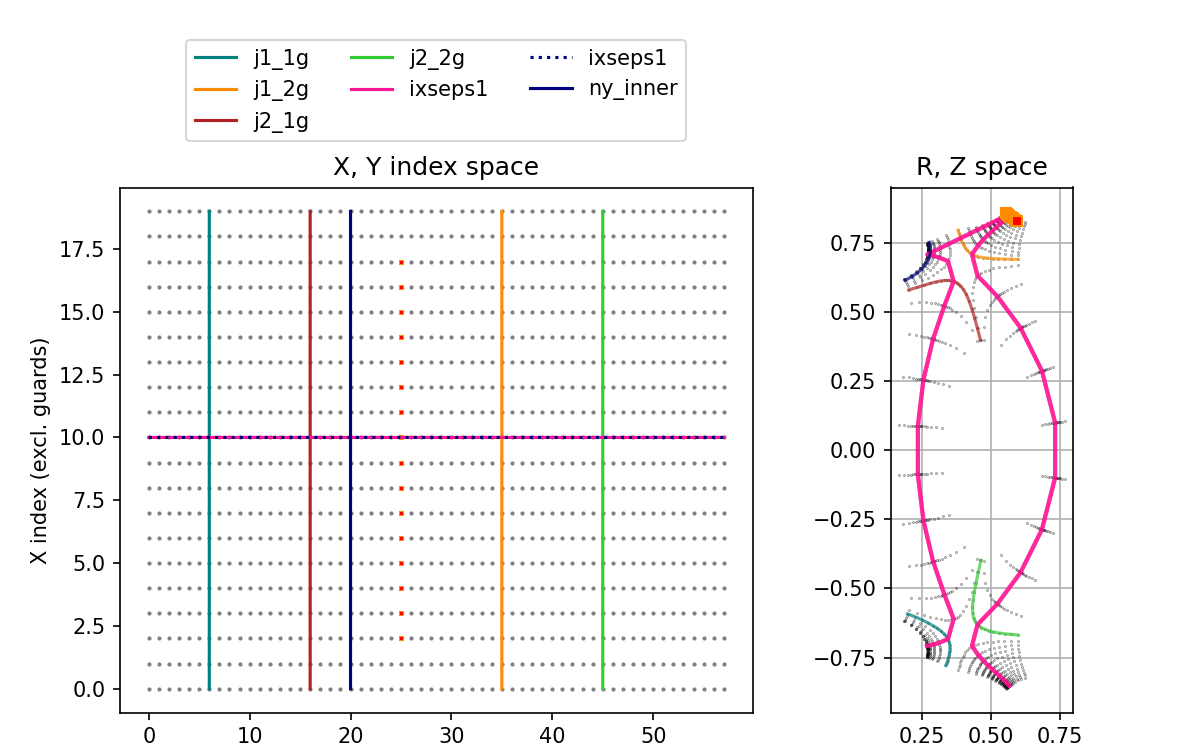

In [ ]:
plot_selection(ds, ds.hermesm.select_region(f"{name}_target_inner_guards"), dpi = 150)

In [ ]:
total = 0
m = ds.metadata
for name in m["targets"]:
    target = ds.hermesm.select_region(f"{name}_target").isel(t=-1)#.mean("x")
    guards = ds.hermesm.select_region(f"{name}_target_guards").isel(theta=-2, t=-1)#.mean("x")
    # plot_selection(ds, guards)

    def wall(param):
        return ((target[param] + guards[param]) / 2).values

    area = wall("dx") * wall("dz") * wall("J") / np.sqrt(wall("g_22"))
    Ne = wall("Ne")
    flux = abs(wall("Vd+")) * wall("Ne")
    flow = flux * area
    b = flow.sum()
    total += b
    
    a = ds[f"pf_int_{name}_d+"].isel(t=-1).values
    # print(Ne)
    print(f"{name}: This calc: {flow.sum():.3e} || Flux calc: {a:.3e}")
print("Total:",total)
    # target["Ne"].values

inner_lower: This calc: 2.284e+20 || Flux calc: -9.360e+20
outer_lower: This calc: 2.568e+21 || Flux calc: -2.591e+21
inner_upper: This calc: 7.658e+20 || Flux calc: -9.421e+20
outer_upper: This calc: 8.817e+20 || Flux calc: -2.571e+21
Total: 4.443947442808781e+21


In [ ]:
gamma_e = 3.5
gamma_i = 3.5
bd = ds.isel(t=-1).squeeze()
flux_down_e, flux_up_e, flux_down_i, flux_up_i, ions_down, ions_up = sheath_boundary_simple_original(bd, gamma_e, gamma_i, bd["Ne"], bd["Te"], bd["Td+"])

In [ ]:
print(f"inner_lower: {ions_down.sum():.3e}")
print(f"outer_lower: {ions_up.sum():.3e}")

inner_lower: 1.486e+21
outer_lower: 4.946e+21


In [ ]:
ds.options["sheath_boundary_simple"]

KeyError: "Key 'sheath_boundary_simple' not in section 'root'"

In [ ]:
target_indices = dict()
target_indices["inner_lower"] = dict(y = m["MYG"], y2 = m["MYG"]+1, yg = m["MYG"]-1)
target_indices["outer_lower"] = dict(y = -m["MYG"]-1, y2 = -m["MYG"]-2, yg = -m["MYG"])
target_indices["inner_upper"] = dict(y = m["ny_inner"] + m["MYG"]-1, y2 = m["ny_inner"], yg = m["ny_inner"] + m["MYG"])
target_indices["outer_upper"] = dict(y = m["ny_inner"] + m["MYG"]*3, y2 = m["ny_inner"]+m["MYG"]*3+1, yg = m["ny_inner"] + m["MYG"]*3 - 1)

In [ ]:
m["keep_yboundaries"]

1

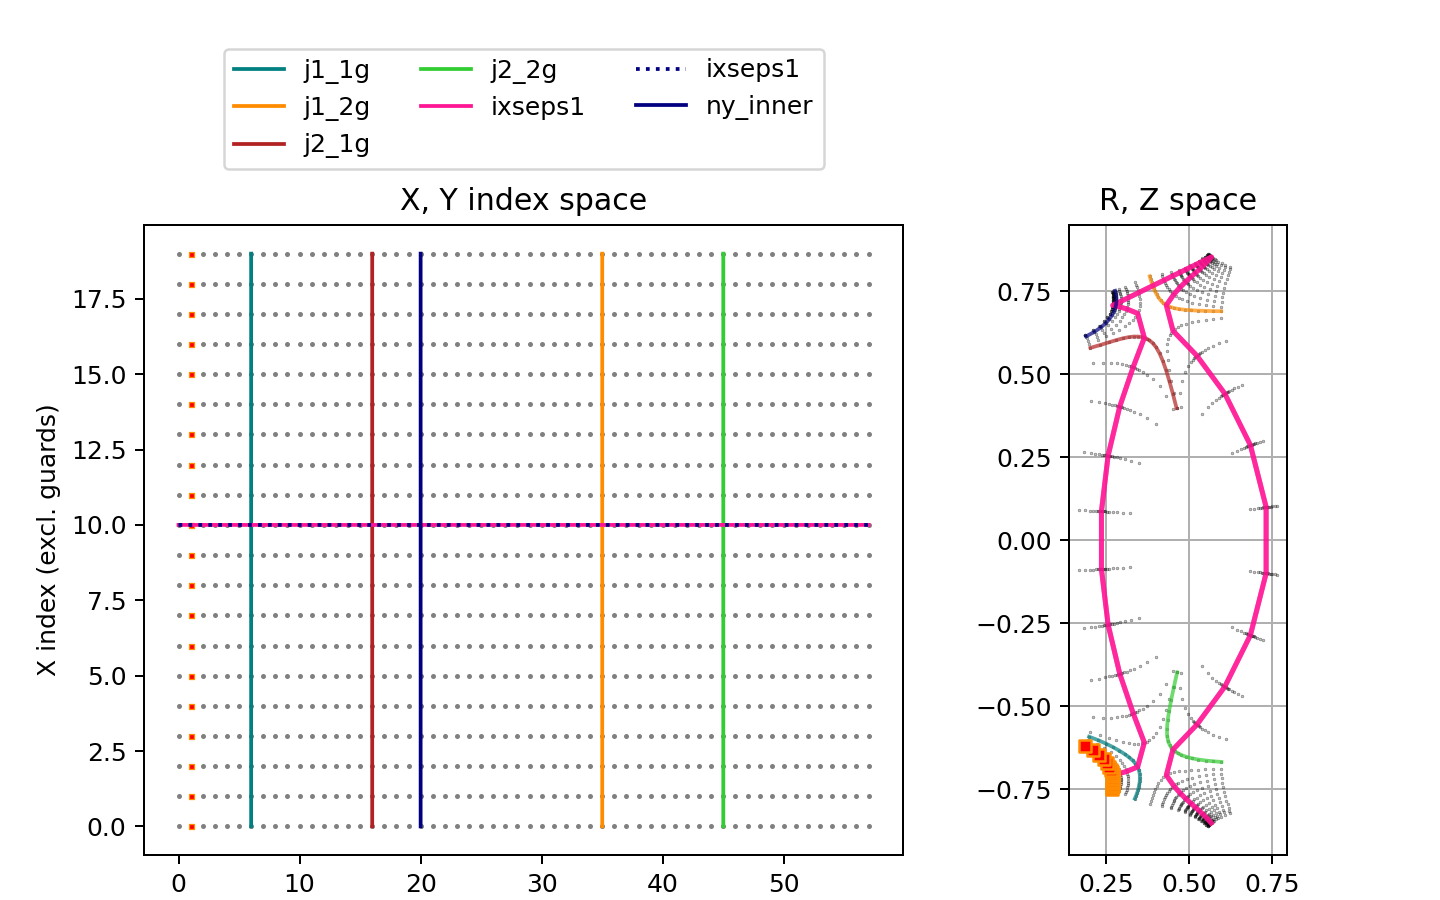

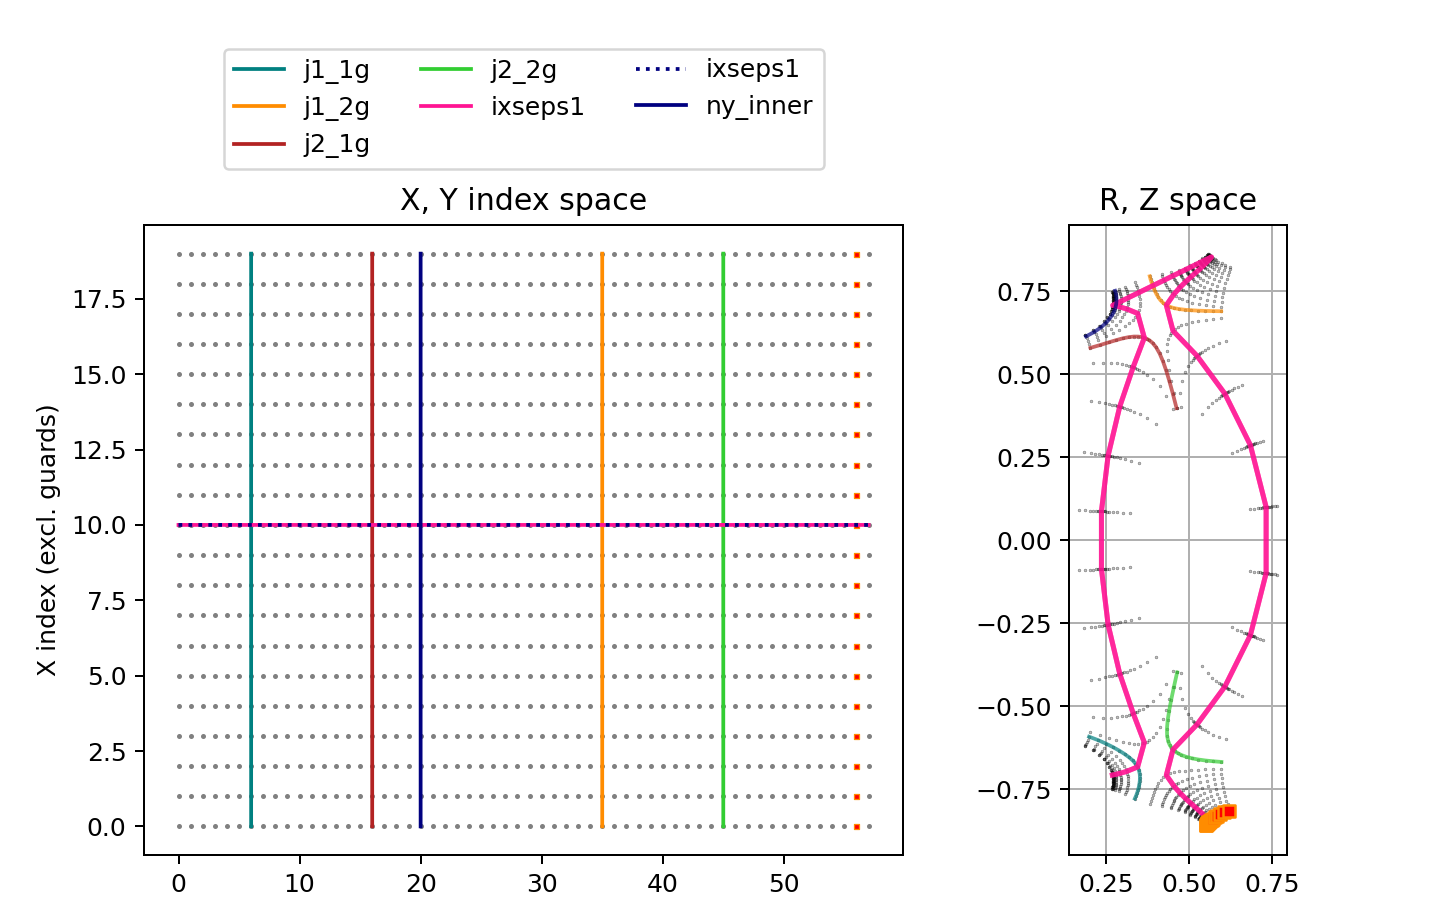

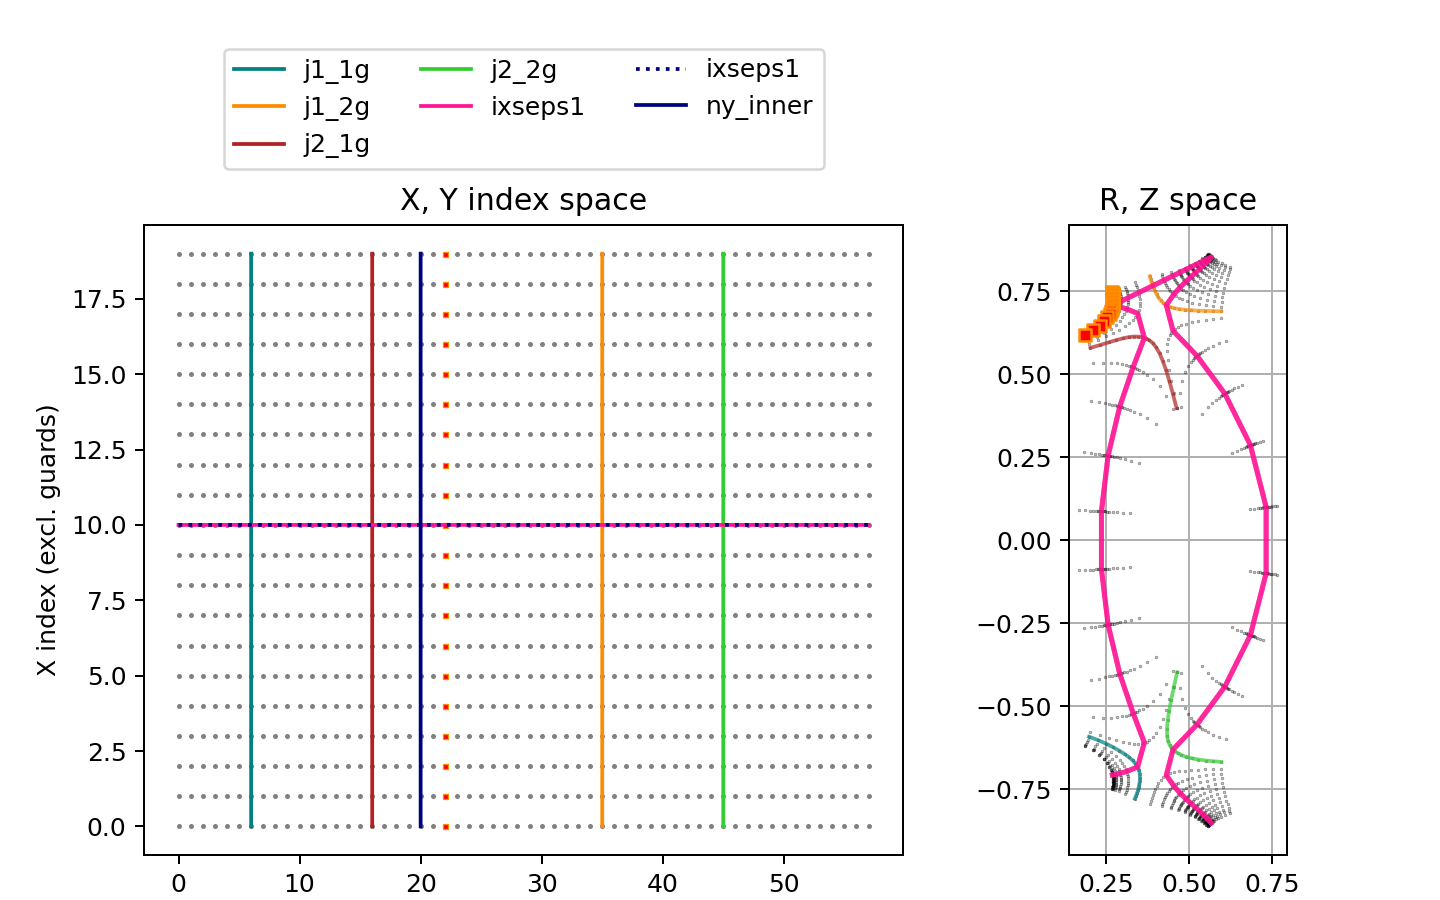

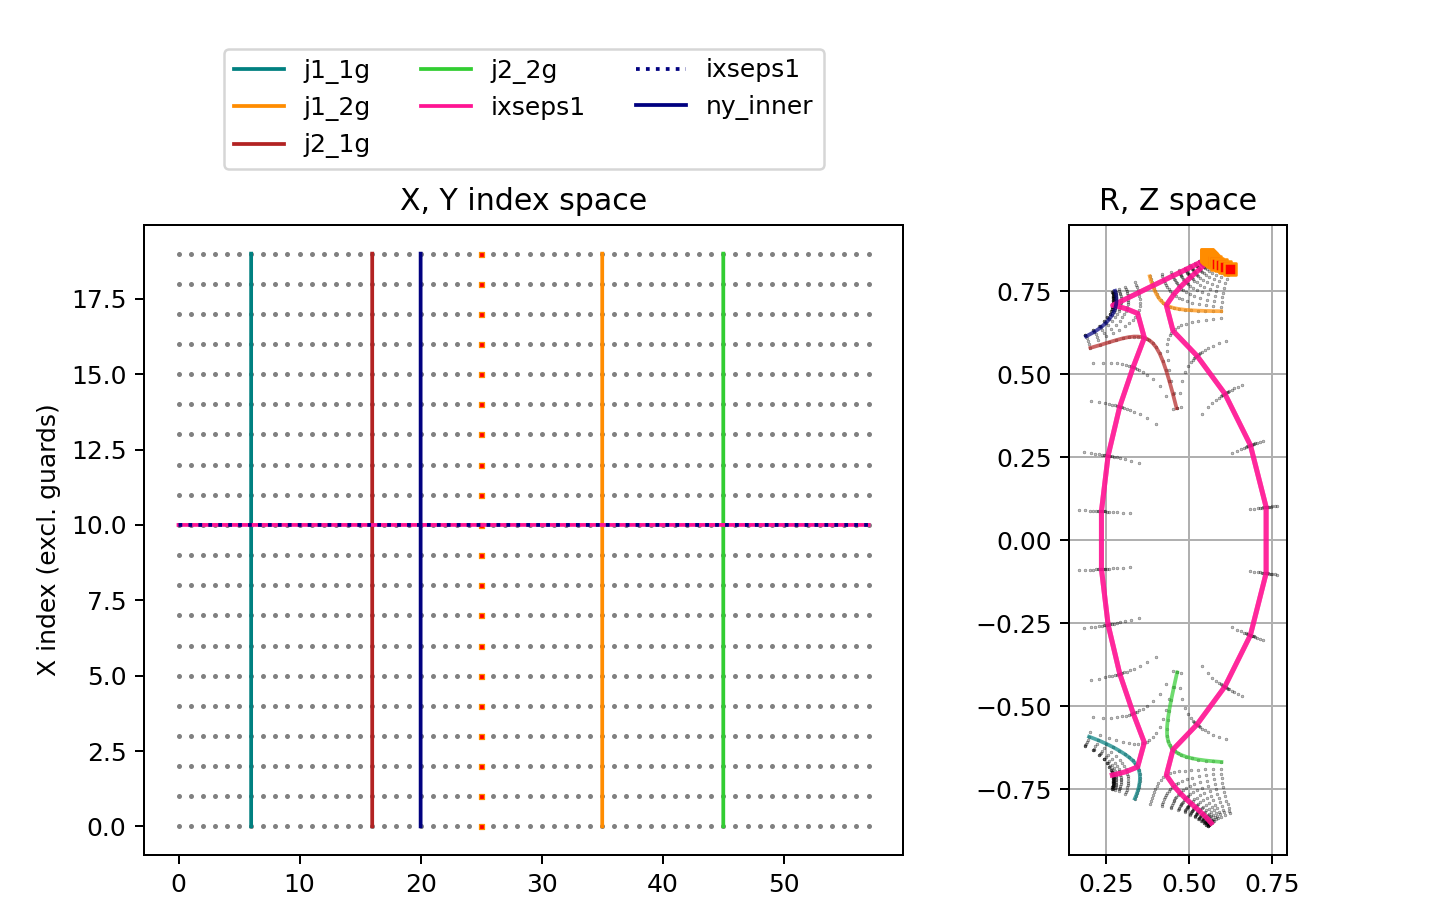

In [ ]:
%matplotlib widget
plt.close("all")
for name in m["targets"]:
    plot_selection(ds, ds.isel(t=-1, theta = target_indices[name]["yg"]), dpi = 180)

# for name in m["targets"]:
    # plot_selection(ds, ds[.hermesm.select_region(f"{name}_target_inner_guards")], dpi = 180)

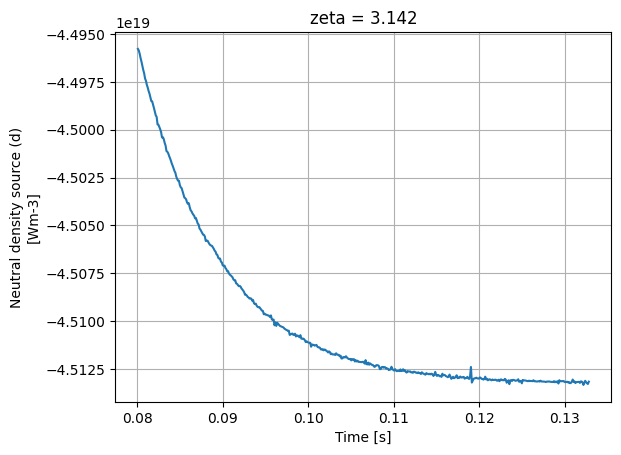

In [ ]:
balance.sel(t=slice(0.08, None)).plot()
plt.grid()

In [ ]:
ds.data_vars

# Core check

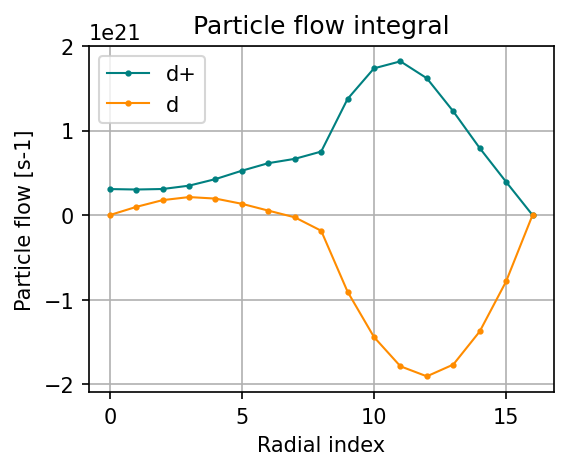

In [108]:
plot_perp_particle_fluxes(ds.isel(t=-1))

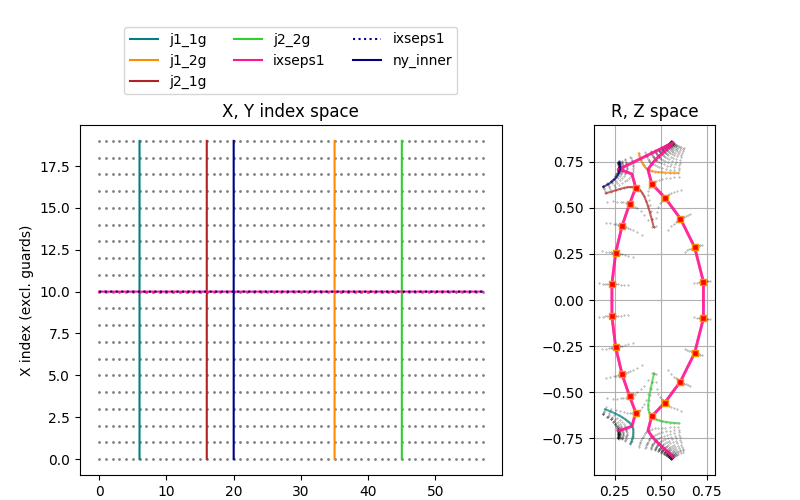

In [105]:
core = ds.hermesm.select_custom_core_ring(8)
sol = ds.hermesm.select_custom_core_ring(8)
plot_selection(ds, core)

In [107]:

# core = ds.hermesm.select_custom_core_ring(0)
core["ParticleFlow_d+_xlow"].sum("theta").isel(t=-1).values


array([1.72071515e+21])

In [106]:
ions = core[f"pf_perp_diff_L_d+"].sum("theta").isel(t=-1).values
neutrals = core[f"pf_perp_diff_L_d"].sum("theta").isel(t=-1).values
print(ions)
print(neutrals)
print(ions+neutrals)

[1.72071515e+21]
[-1.41294929e+21]
[3.07765858e+20]


# Parallel fluxes in SOL

Ion flow: 2.368e+21  || Neutral flow: 1.522e+19


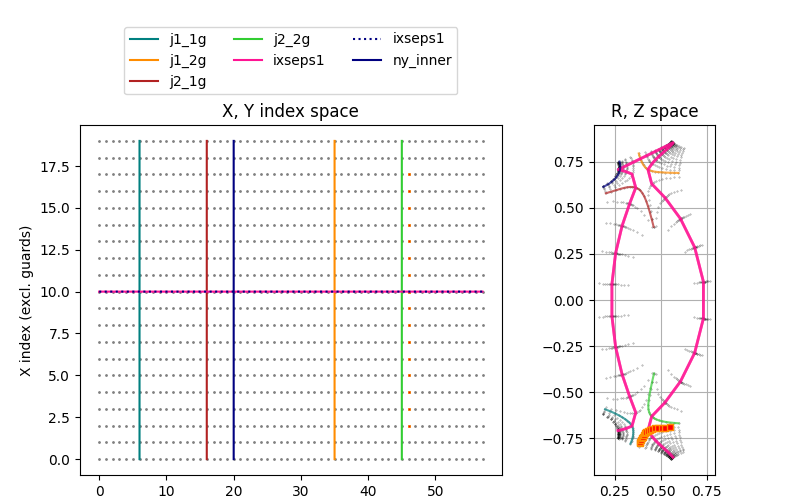

In [135]:

band = ds.isel(theta=-12, x = slice(2,-2), t = -1)
plot_selection(ds, band)
iflux = band["Ne"] * band["Vd+"]
nflux = band["NVd"] / (constants("mass_p")*2)
area = band["J"] / np.sqrt(band["g_22"]) * band["dx"] * band["dz"]
iflow = iflux * area
nflow = nflux * area

print(f"Ion flow: {flow.values.sum():.3e}  || Neutral flow: {nflow.values.sum():.3e}")

Ion flow: 1.428e+20  || Neutral flow: -5.040e+17


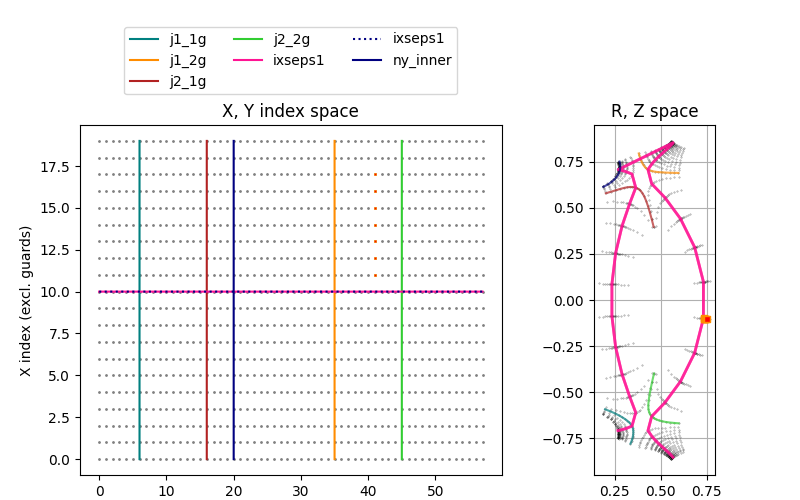

In [153]:

band = ds.isel(theta=-17, x = slice(11,-2), t = -1)
plot_selection(ds, band)
iflux = band["Ne"] * band["Vd+"]
nflux = band["NVd"] / (constants("mass_p")*2)
area = band["J"] / np.sqrt(band["g_22"]) * band["dx"] * band["dz"]
iflow = iflux * area
nflow = nflux * area

print(f"Ion flow: {iflow.values.sum():.3e}  || Neutral flow: {nflow.values.sum():.3e}")

1.8516202503786849e+21


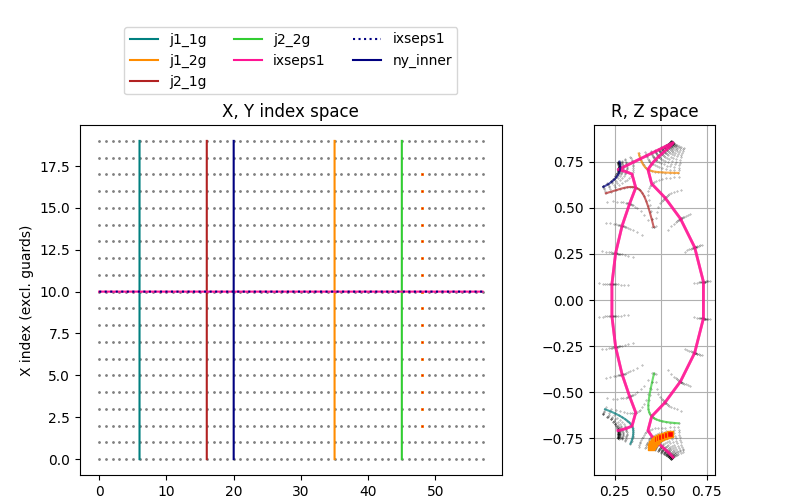

In [80]:
out = -6.97e21+6.62e21

out

-3.499999999999995e+20

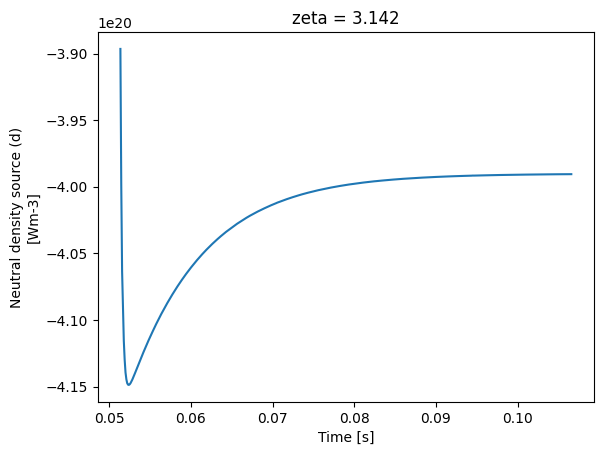

In [74]:
ds["pf_int_total_net"].plot()

In [72]:
(6.97-6.62)/6.97

0.05021520803443324

In [49]:
ds.data_vars

Data variables:
    Bxy                                  (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Dnnd                                 (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Ed+_iz                               (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Ed+_rec                              (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Ed_target_recycle                    (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    Edd+_cx                              (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    EnergyFlow_d+_xlow                   (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    EnergyFlow_d+_ylow                   (t, x, theta) float64 dask.array<chunksize=(530, 20, 7), meta=np.ndarray>
    EnergyFlow_e_xlow                    (t, x, theta) float64 dask.arra

In [58]:
(ds["Sd_target_recycle"] * ds["dv"]).isel(x=slice(2,-2)).sum().values

array(6.61786471e+21)

In [61]:
ds = casestore["base"].ds.isel(t=-1)
tot = 0
for name in m["targets"]:
    # tot += ds[f"pf_int_recycle_{name}_target_d"].values
    # target = ds.hermesm.select_region(targetname).squeeze
    tot += ds[f"pf_{name}_target_d+"].sum().values
    
tot

-6.971255365419361e+21

In [66]:
ds[f"pf_{target_name}_target_d+"].values

array([            nan,             nan, -2.21927464e+19, -2.44975586e+19,
       -2.92798982e+19, -3.69546501e+19, -4.81056327e+19, -6.33643142e+19,
       -8.30671428e+19, -1.06459480e+20, -1.35679217e+20, -1.89979007e+20,
       -2.71380582e+20, -3.46886926e+20, -3.66153103e+20, -3.22919965e+20,
       -2.63761792e+20, -2.41305413e+20,             nan,             nan])